In [1]:
import os
from json import loads, dumps
FOLDER_PATH = 'data/jmetal-GA-4000-20-20/'
files = os.listdir(FOLDER_PATH);

In [25]:
from executor import execute_single_py_program, detect_divergence
from transpiler import CirqCircuit
from utils import get_qiskit_content_by_program_id
from pprint import pprint

def cirq_most_deviant_config(path):
    content = loads( open( path ).read() )
    perm = content['jmetal']['found_perm']
    # print(get_qiskit_content_by_program_id(content['program_id']))
    qiskit_src = get_qiskit_content_by_program_id(content['program_id'], remove_cx3=True)
    
    # print(qiskit_src)
    
    c = CirqCircuit(qiskit_src)
    metadata, src = c.get_follow_up({  "add_unitary": False, "transformations": perm })
    metadata, unopt_src = c.get_follow_up({  "add_unitary": False })

    return { "unopt": unopt_src, "opt": src, "orig_stat": content['jmetal']['solution_stats'] }

def run_times(path, times=30):
    sources = cirq_most_deviant_config(path)
    
    unopt_dist, _ = execute_single_py_program(sources['unopt'])
    
    output = []
    
    for _ in range(times):
        opt_dist, _ = execute_single_py_program(sources["opt"])
        output.append( detect_divergence( { "res_A": unopt_dist, "res_B": opt_dist } ) )
    
    return { "out": output, "orig_stat": sources['orig_stat']}
    

In [31]:
import matplotlib.pylab as plt



def draw(items, orig_stat):
    plt.plot(items)
    plt.plot([orig_stat] * len(items), label=f"jmetal found val={orig_stat}")
    plt.legend(loc="center right")
    plt.show()

def draw_both_for(path):
    output = run_times(path)
    draw( [ el['statistic'] for el in output['out'] ], output['orig_stat']['statistic'] ) 
    draw( [ el['p-value'] for el in output['out'] ], output['orig_stat']['p-value'] ) 

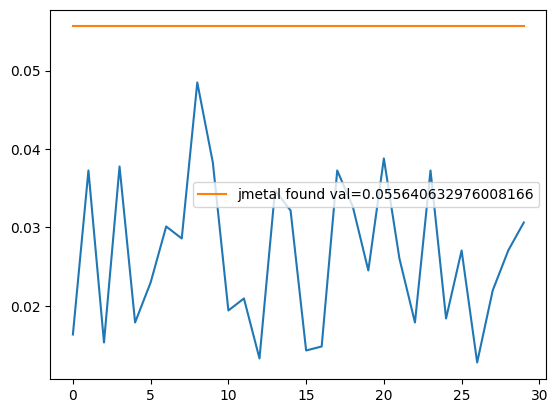

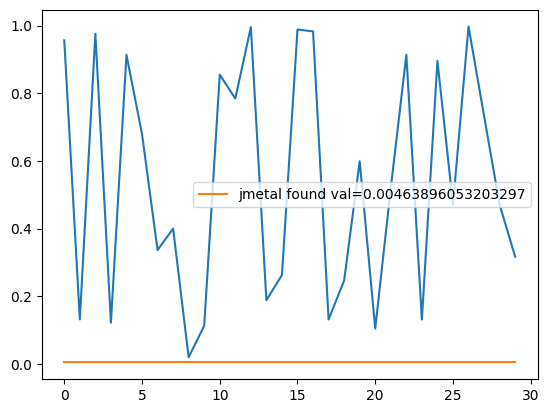

In [34]:
draw_both_for(FOLDER_PATH + files[0])